# Workshop challenge

## Package installing and data import

In [1]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale
from sklearn.manifold import TSNE

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.lof import LOF
# from pyod.models.pca import PCA as pyod_PCA
from pyod.models.iforest import IForest

Using TensorFlow backend.


In [2]:
sys.path.append("..") #to enable importing from outlierutils
from outlierutils import plot_top_N, plot_outlier_scores, LabelSubmitter 
url = "https://unsupervised-label-api-pg.herokuapp.com/" # Link to the API


## Data Imports

In [149]:
data_path = '../data'
x_kdd = pd.read_pickle(os.path.join(data_path, 'x_kdd.pkl'))
x_kdd = x_kdd.drop_duplicates()
if x_kdd.index.max() > len(x_kdd):
    x_kdd = x_kdd.reset_index()
print(f'Data set size: {x_kdd.shape}')

Data set size: (48113, 41)


In [150]:
x_kdd.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,tcp,ftp_data,SF,203.0,0.0,0.0,0.0,0.0,0.0,...,255.0,125.0,0.49,0.02,0.49,0.00,0.0,0.0,0.0,0.0
1,0.0,tcp,http,SF,216.0,4828.0,0.0,0.0,0.0,0.0,...,5.0,231.0,1.00,0.00,0.20,0.02,0.0,0.0,0.0,0.0
2,0.0,udp,other,SF,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,6.0,0.02,0.63,1.00,0.00,0.0,0.0,0.0,0.0
3,0.0,tcp,http,SF,408.0,13133.0,0.0,0.0,0.0,0.0,...,73.0,231.0,1.00,0.00,0.01,0.03,0.0,0.0,0.0,0.0
4,0.0,udp,domain_u,SF,45.0,129.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0


## Challenge Description

You just imported a data set, `x_kdd`, with 48K rows. The dataset was collected by by MIT Lincoln Labs in 1999, by operating a LAN-network as usual, and additionally carrying out various attacks. This specific dataset (which is a subset of the original dataset) has "normal" traffic as inlier class, and several attacks (buffer_overflow, ftp_write, imap, ...) as outlier class. Although this data does not represent payment fraud, it is relevant because of the mixed data type. 


There are no labels available, there is therefore also no split in train and test. 
The target is to predict as many true positives as possible (each positive gets you a positive score), and as few false positives as possible (each false positive subtracts a small score). So only submit points that may likely be positives!!


Be selective, just submitting all points, or random points, will not get you a good score :)

- Each true positive found yields **500** points
- Each false positive costs **25** points

**Hints**

- The fraction of positives is less than 1%. Random guessing to gather labels is therefore unlikely to pay off. 
- When sufficiently many positive labels are available, this information may be used to further tune unsupervised algorithms, or to train a supervised classifier


First clean up the data: convert categorical columns to one-hot encoded, and MinMax-scale all features. Do not remove any rows!



In [151]:
# clean-up code here
x_kdd_clean = pd.get_dummies(x_kdd)

In [152]:
x_kdd_clean.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromissed,...,service_uucp,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,216.0,4828.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,408.0,13133.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,45.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [153]:
scaler = StandardScaler()
x_kdd_clean = scaler.fit_transform(x_kdd_clean)

In [154]:
x_kdd_clean.shape

(48113, 79)

## Outlier detection: your code!


In [65]:
x_kdd_clean.shape

(48113, 79)

In [66]:
samples = np.random.choice(range(0, len(x_kdd_clean)), 500)

In [67]:
MAX_N_TSNE = 4000 #Avoid overly long computation times with TSNE. Values < 4000 recommended 

X_2D = TSNE(n_components=2).fit_transform(x_kdd_clean[samples]) # transform to 2-D space for plotting

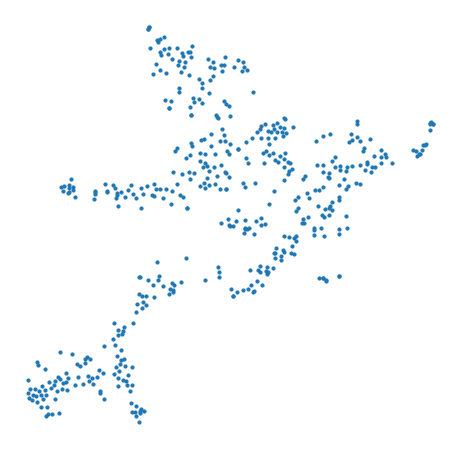

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_2D[:, 0], X_2D[:, 1], marker='o', s=10)
plt.axis('off')
plt.show() 

In [155]:
gmm = GaussianMixture(n_components=20, covariance_type='full', random_state=1) # try also spherical
gmm.fit(x_kdd_clean)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=20, n_init=1,
                precisions_init=None, random_state=1, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [156]:
clf = KNN(method='median', n_neighbors=20)
clf.fit(x_kdd_clean)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores (use these for scoring!)


In [157]:
lof = LOF(n_neighbors=30, contamination=0.01)
lof.fit(x_kdd_clean)

y_train_pred = lof.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = lof.decision_scores_

indices_outliers_lov = get_top_N_indices(lof.decision_scores_)

In [158]:
def get_top_N_indices(scores, N=100):
    """ Helper function. Returns the indices of the points with the top N highest outlier scores
    """
    return np.argsort(scores)[::-1][:N]

## API submission

Submit your predictions to the API with a LabelSubmitter object. 
This object has a `.post_predictions()` method to submit predictions, and a `.get_labels()` method to retrieve the labels (positives and negatives) of all previous submissions. 

Use the parameter `endpoint='kdd'` option for this challenge. 

In [31]:
username='CANBERRA'
password='iusHr'
if not ('ls' in locals() and ls.jwt_token): #only if no labelsubmitter with .jwt_token is available
    ls = LabelSubmitter(username=username,
                       password=password,
                       url=url)


In [32]:
indices_outliers

array([43332, 45522,  7997, 41403, 19590,  5822,  2168,  3010, 42338,
       29073])

In [159]:
indices_outliers_gmm = get_top_N_indices(-scores_gmm, 1000)
sample_scores_knn = get_top_N_indices(clf.decision_scores_, 1000)
indices_outliers_lov = get_top_N_indices(lof.decision_scores_, 1000)

In [160]:
all_indices = np.concatenate([indices_outliers_knn, indices_outliers_lov, indices_outliers_gmm])

In [161]:
unique, counts = np.unique(all_indices, return_counts=True)
counts_dict = dict(zip(unique, counts))

In [162]:
top_indices = unique[counts >=2]

In [163]:
top_indices

array([  183,   185,   354,   567,   592,   634,   909,  1380,  1636,
        1712,  1854,  2140,  2168,  2219,  2505,  2565,  2774,  2824,
        2882,  3010,  3024,  3050,  3095,  3116,  3183,  3315,  3480,
        3730,  3788,  3813,  4003,  4418,  4575,  4632,  5140,  5156,
        5227,  5281,  5421,  5610,  5679,  5822,  5977,  6102,  6267,
        6598,  6797,  6979,  6986,  7134,  7296,  7375,  7599,  7825,
        8330,  8500,  8569,  8702,  8896,  9150,  9541,  9735,  9774,
       10099, 10364, 10416, 10650, 11096, 11469, 11601, 11633, 12071,
       12181, 12248, 12268, 12300, 12499, 12569, 12936, 12953, 13308,
       13485, 13762, 14112, 14223, 14876, 15306, 15664, 15839, 15947,
       16300, 16473, 16524, 16533, 16794, 16818, 16840, 17001, 17221,
       17359, 17441, 17711, 17994, 18130, 18177, 18389, 18618, 18738,
       18926, 19133, 19222, 19242, 19456, 19590, 19783, 20126, 20513,
       20896, 20932, 21131, 21465, 21517, 21653, 21675, 22017, 22636,
       23054, 23102,

In [164]:
top_indices.shape

(268,)

In [106]:
indices_outliers_knn, indices_outliers_lov, indices_outliers_gmm

(array([31939, 11601,   354, 28725,   634, 29073, 33484,  4003, 36830,
        35402, 17359, 26407, 27169, 26153, 23203, 24119, 12248, 17994,
         8500, 43631, 25248, 24943, 28477, 26714, 43912, 37185, 41013,
        26828, 43637, 47375, 31766,    57, 14625, 19685, 11469, 13741,
        27299, 36749, 21950,  8170,  5018,    83, 31380,  8896, 32941,
         7157,  1712, 42332, 24118, 36656, 30328, 42308, 20513, 12071,
         6663, 47663, 28016, 45624, 20197, 23102, 45808, 16818, 37231,
        42539, 47315, 22525,  6156, 25397, 36880, 42711, 39741, 45616,
        37966, 33189, 45414, 41084, 23557, 21131, 46837,  8543,  9735,
        45726, 19783, 42766, 12953, 44515,  6797, 11633, 30283, 27742,
        37818, 25361, 29798, 29802, 22636, 34315, 24475,  3050, 45860,
        44604]),
 array([31939,   354, 11601, 40244, 28725,  5747, 30741, 45651,  8221,
        39080, 46247,  8569, 16794, 34887,  8500, 38303,  5458, 33413,
        18738, 16524,  7375, 36685, 14264, 16210, 35409, 447

In [165]:
ls.post_predictions(idx=top_indices, endpoint='kdd')

submitted 145 new points
number of positives in submission: 47
precision of submission: 17.54%


In [ ]:
6797, 16794, 20513, 27853

In [166]:
result = ls.get_labels(endpoint='kdd')

number of predictions made: 556
total number of positives found: 67
total precision: 12.05%
score: 21275


In [113]:
idxes = result[result == 1].index

In [116]:
-scores_gmm[idxes], clf.decision_scores_[idxes], lof.decision_scores_[idxes]

(array([ 682.15543792,  694.18410907, -422.75658503,   -2.71791063,
         367.66295525,   32.64445926,   90.36052879,  694.18410874,
         408.20633129,  694.18410894]),
 array([ 64.97751227,   1.41467677, 273.77780397,   8.77877875,
         60.8083911 ,  25.83712834,   5.58302147,   1.41525558,
         69.0671873 ,   1.41512453]),
 array([1.62564096, 8.47677516, 3.0792691 , 3.59412069, 1.15790918,
        3.06600891, 3.21402036, 5.91630681, 1.73415625, 5.19730714]))